EfficientNetB0 Modeli :

Daha yeni ve daha güçlü bir mimaridir. Hem doğruluk hem de verimlilik açısından çok optimize edilmiştir.

Bu projede transfer öğrenme yöntemi ile EfficientNetB0 modeli kullanıldı.

Tüm katmanları dondurulduktan sonra kendi sınıflarımıza uygun yeni sınıflandırıcı katmanlar eklendi.

Model yaklaşık %98 , doğruluk ile MobileNetV2’ye yakın hatta bazı sınıflarda daha iyi performans gösterdi.

Daha yüksek doğruluk ve genel performans için EfficientNetB0 tercih edildi. Gelişmiş yapısı sayesinde sınıflar arasındaki küçük farkları daha iyi yakalayabiliyor. 

MobilNet'e göre daha derin ama hâlâ verimli bir modeldir.

In [1]:
# Bu hücrede projemde kullanacağım tüm temel kütüphaneleri içe aktardım. 

# Görüntü işleme , veri analizi, model kurma ve eğitim sürecini kontrol etmek gibi işlemler için bu kütüphaneler gerekli.

# Veri Bilimi Kütüphaneleri

import numpy as np                # Sayısal işlemler ve diziler için

import pandas as pd              # Veri çerçevesi oluşturmak ve analiz için

import matplotlib.pyplot as plt  # Grafik çizimleri için

import tensorflow as tf          # Derin öğrenme modelleri oluşturmak için

from sklearn.model_selection import train_test_split  # Veriyi eğitim/test olarak bölmek için

from PIL import Image            # Görüntüleri yüklemek ve işlemek için

import cv2 as cv                 # Görüntü ve video işleme için OpenCV kütüphanesi


# TensorFlow ve Keras Kütüphaneleri

from tensorflow import keras     # Keras API'si üzerinden model oluşturmak için

from tensorflow.keras import layers, models  # Katmanlar ve modeller oluşturmak için

from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Görüntü verisi artırma (augmentation) için

from tensorflow.keras.layers import Dense, Dropout  # Yoğun ve Dropout katmanları için

from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint  # Eğitim sürecini kontrol etmek için geri çağırmalar

from tensorflow.keras.optimizers import Adam  # Adam optimizasyon algoritması

from tensorflow.keras.applications import EfficientNetB0  # EfficientNetB0 önceden eğitilmiş model

from tensorflow.keras import Model  # Özelleştirilmiş model oluşturmak için

# Not: İleride ön işleme katmanı gerekirse aşağıdaki gibi eklenebilir:

# from tensorflow.keras.layers import Rescaling  # Piksel değerlerini 0-1 aralığına ölçeklendirmek için


# Sistem Kütüphaneleri

from pathlib import Path          # Dosya yollarıyla çalışmak için

import os                         # İşletim sistemiyle etkileşim için


# Değerlendirme Metrikleri

from sklearn.metrics import classification_report, confusion_matrix  # Sınıflandırma raporu ve karışıklık matrisi

import itertools                  # Yinelenebilir elemanlar oluşturmak için (örneğin: matris hücreleri)


In [2]:
# Bu kod hücresinde, proje verilerimin bulunduğu klasörü  tarayarak 
#içindeki sınıfların isimlerini, görsel sayısını ve dosya uzantılarını 
# ekrana yazdırıyorum. Bu , verinin düzgün yerleştirilip yerleştirilmediğini kontrol etmek için önemli bir adımdı.

from pathlib import Path
import os


# 1. Ana veri klasörünün yolunu tanımla

# 'data' klasörünüzün içinde 'train/' ve 'test/' alt klasörleri olmalı

dataset_root = Path("/Users/macbook/Desktop/Fire Detection from CCTV/data")


# 2. Alt klasörleri dolaşarak bilgileri yazdır

# Klasör ismi, sınıf adı (son klasör), görsel sayısı ve uzantı bilgilerini yazdırır

for root, dirs, files in os.walk(dataset_root):

    class_name = os.path.basename(root)  # Sınıf adı klasörün son parçasıdır
    
    if files:
        extensions = set(os.path.splitext(f)[1][1:] for f in files)  # Uzantıları ayıkla

        print(f"Klasör Yolu: {root}")
        print(f" → Sınıf Adı: {class_name}")
        print(f" → Görsel Sayısı: {len(files)}")
        print(f" → Dosya Uzantıları: {extensions}\n")


Klasör Yolu: /Users/macbook/Desktop/Fire Detection from CCTV/data
 → Sınıf Adı: data
 → Görsel Sayısı: 1
 → Dosya Uzantıları: {''}

Klasör Yolu: /Users/macbook/Desktop/Fire Detection from CCTV/data/test/smoke
 → Sınıf Adı: smoke
 → Görsel Sayısı: 30
 → Dosya Uzantıları: {'jpg'}

Klasör Yolu: /Users/macbook/Desktop/Fire Detection from CCTV/data/test/default
 → Sınıf Adı: default
 → Görsel Sayısı: 84
 → Dosya Uzantıları: {'jpg'}

Klasör Yolu: /Users/macbook/Desktop/Fire Detection from CCTV/data/test/fire
 → Sınıf Adı: fire
 → Görsel Sayısı: 57
 → Dosya Uzantıları: {'jpg'}

Klasör Yolu: /Users/macbook/Desktop/Fire Detection from CCTV/data/train
 → Sınıf Adı: train
 → Görsel Sayısı: 1
 → Dosya Uzantıları: {''}

Klasör Yolu: /Users/macbook/Desktop/Fire Detection from CCTV/data/train/smoke
 → Sınıf Adı: smoke
 → Görsel Sayısı: 258
 → Dosya Uzantıları: {'jpg'}

Klasör Yolu: /Users/macbook/Desktop/Fire Detection from CCTV/data/train/default
 → Sınıf Adı: default
 → Görsel Sayısı: 161
 → Dosya 

In [3]:
from pathlib import Path
import os
import pandas as pd


# 1. Görsel verisetinin ana klasör yolunu tanımla

# Klasör yapısı:

# data
# train
# default
# fire
# smoke
# test
# default
# fire
# smoke

dataset_dir = Path("/Users/macbook/Desktop/Fire Detection from CCTV/data")


# 2. Farklı uzantılardaki tüm görsellerin yollarını topla

filepaths = (
    list(dataset_dir.glob("**/*.JPG")) +
    list(dataset_dir.glob("**/*.jpg")) +
    list(dataset_dir.glob("**/*.png"))
)


# 3. Her bir görselin üst klasör adını (sınıf) etiket olarak al

labels = [p.parent.name for p in filepaths]  # p.parent.name etiketi verir


# 4. Görsel yolu ve etiket bilgileri ile bir DataFrame oluştur

image_df = pd.DataFrame({
    "filepaths": [str(p) for p in filepaths],  # Yol bilgisini string'e çevir
    "labels": labels
})


# 5. Doğruluk kontrolü için son 5 satırı göster

image_df.tail()


,filepaths,labels
859,/Users/macbook/Desktop/Fire Detection from CCT...,fire
860,/Users/macbook/Desktop/Fire Detection from CCT...,fire
861,/Users/macbook/Desktop/Fire Detection from CCT...,fire
862,/Users/macbook/Desktop/Fire Detection from CCT...,fire
863,/Users/macbook/Desktop/Fire Detection from CCT...,fire


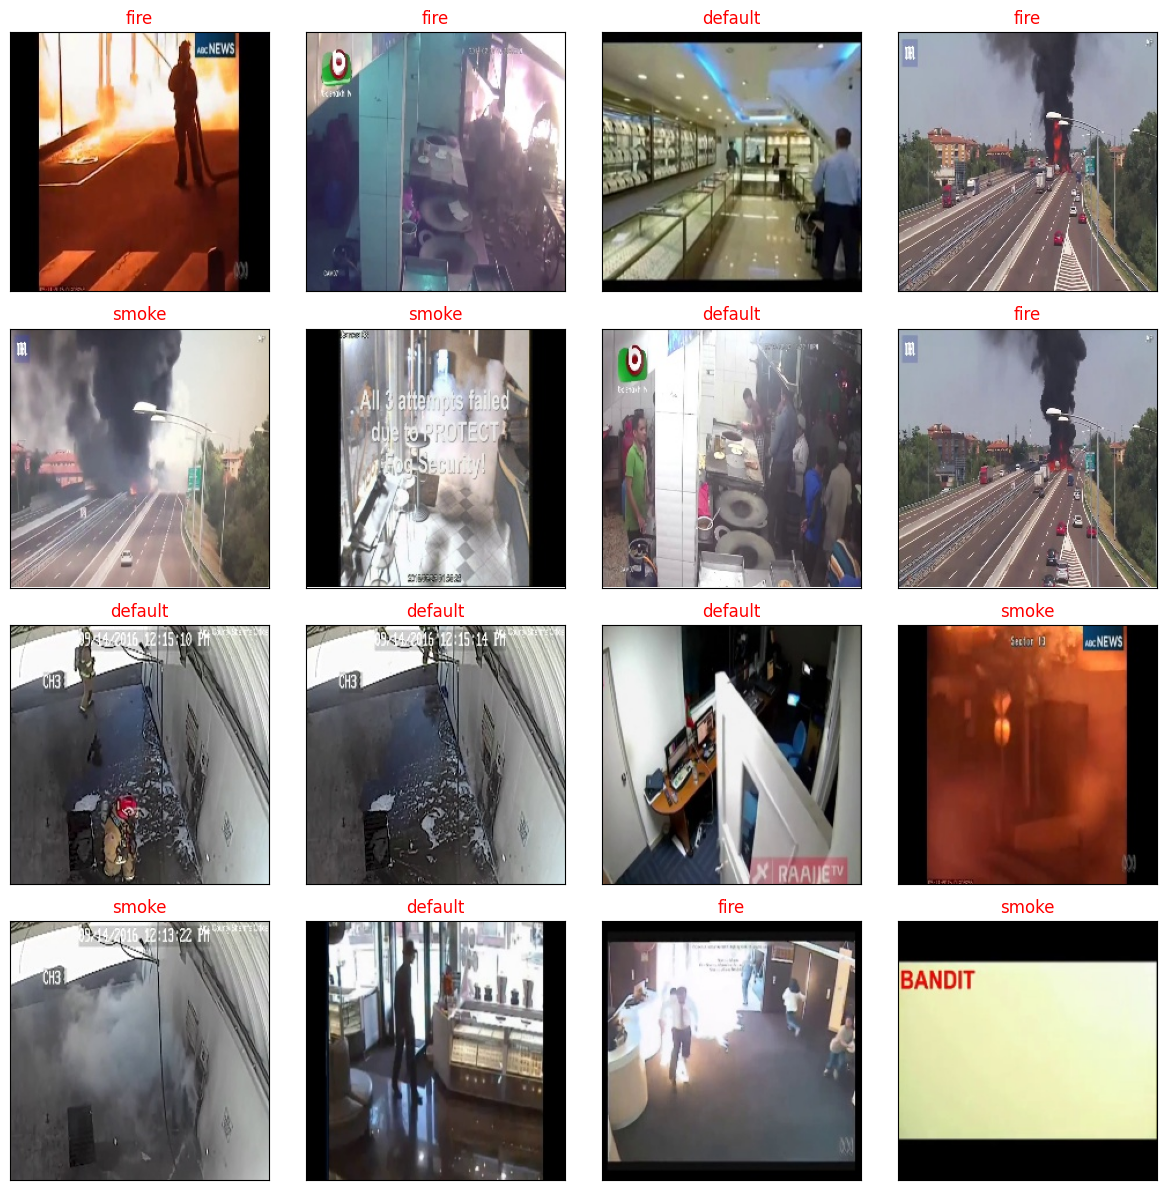

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# DataFrame'den rastgele 16 görseli ve etiketlerini görselleştir


# 1. 0 ile toplam satır sayısı arasında rastgele 16 indeks seç

random_indices = np.random.randint(0, len(image_df), 16)

# 2. 4x4'lik bir subplot ağı oluştur (toplam 16 görsel)

fig, axes = plt.subplots(4, 4, figsize=(12, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

# 3. Her görsel için alt grafikte resmi göster ve başlık olarak etiketi yaz

for ax, idx in zip(axes.flat, random_indices):

    img_path = image_df.filepaths[idx]    # Görselin yolu

    label   = image_df.labels[idx]        # Görselin etiketi (default, fire, smoke)

    image = Image.open(img_path)          # PIL ile görseli aç

    ax.imshow(image)                      # Görseli subplot'a yerleştir

    ax.set_title(label, color='red')      # Etiketi kırmızı renkte başlık olarak ekle

# 4. Alt grafikler arası boşlukları ayarla ve göster

plt.tight_layout()
plt.show()


In [5]:
from sklearn.model_selection import train_test_split


# Veriyi eğitim ve test olarak ayır


train_df, test_df = train_test_split(
    
    image_df,        # Görsel yolları ve etiketleri içeren DataFrame

    test_size=0.2,   # Verinin %20'sini test verisi olarak ayır

    shuffle=True,    # Verileri karıştırarak bölmek çeşitliliği artırır

    random_state=42  # Rastgeleliği sabitlemek için sabit tohum değeri
)


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 1. EfficientNetB0 için veri ön işleme fonksiyonu ile ImageDataGenerator oluştur


train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,

    validation_split=0.2   # Eğitim verisinin %20’si validasyon için ayrılır
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
    
    # Test verisi için validation_split gerekmez
)


In [7]:

# 2. Eğitim verisi için DataFrame'den veri üretici oluştur

train_images = train_generator.flow_from_dataframe(

    dataframe=train_df,              # Eğitim verilerini içeren DataFrame

    x_col='filepaths',              # Görüntü dosyalarının yolları

    y_col='labels',                 # Görüntülere karşılık gelen etiketler

    target_size=(224, 224),        # Görüntü boyutu 224x224 olarak yeniden boyutlandırılır

    color_mode='rgb',              # Renkli görüntüler (RGB)

    class_mode='categorical',      # Çok sınıflı sınıflandırma (one-hot kodlama)

    batch_size=32,                 # Her seferinde 32 görüntü alınır

    shuffle=True,                  # Veriler karıştırılır

    seed=42,                       # Rastgelelik için sabit seed

    subset='training'              # %80 eğitim verisi
)





# 3. Test verisi için veri üretici oluştur


test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,             
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',     # Çok sınıflı sınıflandırma
    batch_size=32,
    shuffle=False                 # Test verisi sırasını korur
)


Found 553 validated image filenames belonging to 3 classes.
Found 173 validated image filenames belonging to 3 classes.


In [9]:
# 5. EfficientNetB0 modelini yükle (önceden eğitilmiş)

from tensorflow.keras.applications import EfficientNetB0  # EfficientNetB0 modelini içe aktar

# EfficientNetB0 modelini ImageNet ağırlıklarıyla yükle (üst katmanlar hariç)

pretrained_model = EfficientNetB0(
    input_shape=(224, 224, 3),   # Giriş boyutu: 224x224 piksel, 3 kanal (RGB)

    include_top=False,           # Üst sınıflandırıcı katmanı dahil değil

    weights='imagenet',          # ImageNet üzerinde önceden eğitilmiş ağırlıklar

    pooling='avg'                # Global average pooling katmanı (tek boyutlu vektör çıkışı)
)

# Modelin tüm katmanlarını dondur (eğitim sırasında güncellenmesin)

for layer in pretrained_model.layers:
    
    layer.trainable = False      # Katman ağırlıkları eğitilmeyecek şekilde ayarlanır


In [10]:
# 6. EfficientNetB0 üzerine özel katmanlar ekle (özelleştirme)

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model



# 1. Giriş katmanı olarak EfficientNetB0 modelinin girişi alınır

inputs = pretrained_model.input  # Giriş şekli: (None, 224, 224, 3)

# 2. İlk Dense katmanı: 256 nöron, ReLU aktivasyon fonksiyonu

x = Dense(256, activation='relu')(pretrained_model.output)

# 3. Overfitting'i azaltmak için %20 dropout uygulama

x = Dropout(0.2)(x)

# 4. Aynı şekilde ikinci bir Dense + Dropout katmanı ekle

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

# 5. Çıkış katmanı: 3 sınıf için softmax aktivasyonu (default, fire, smoke)

outputs = Dense(3, activation='softmax')(x)

# 6. Giriş ve çıkışları birleştirerek modeli tanımla

model = Model(inputs=inputs, outputs=outputs)

# 7. Modelin özetini (katman yapısını) yazdır

model.summary()  # Model yapısını ve parametre sayısını göster


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,444,070 (16.95 MB)

 Trainable params: 394,499 (1.50 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
# 7. Eğitim sırasında en iyi ağırlıkları kaydetmek için Callback

from tensorflow.keras.callbacks import ModelCheckpoint


# Not: save_weights_only=True kullanıldığında dosya adı ".weights.h5" ile bitmeli

checkpoint_path = "fires_classif_model_efficientnet.weights.h5"

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,       # Ağırlıkların kaydedileceği dosya yolu

    save_weights_only=True,         # Sadece ağırlıklar kaydedilir, model yapısı değil

    monitor="val_accuracy",         # Doğrulama (validation) doğruluğunu izler
    
    save_best_only=True             # Doğruluk iyileştiğinde sadece o zaman kaydeder
)


In [12]:
# 8. Eğitim sırasında erken durdurma (early stopping) callback'i

from tensorflow.keras.callbacks import EarlyStopping



early_stopping = EarlyStopping(
    monitor="val_loss",            # Doğrulama kaybını izler

    patience=5,                    # 5 epoch boyunca iyileşme olmazsa durdurur
    
    restore_best_weights=True      # En iyi ağırlıkları geri yükler
)


In [14]:
from tensorflow.keras.optimizers import Adam


# 9. Modeli derleme (compile)


model.compile(
    optimizer = Adam(0.0001),               # Öğrenme oranı 0.0001 olan Adam optimizasyon algoritması

    loss = 'categorical_crossentropy',      # Çok sınıflı sınıflandırma için uygun kayıp fonksiyonu
    
    metrics = ['accuracy']                  # Eğitim sırasında doğruluk metriğini takip eder
)


# 10. Modeli eğitme (fit)


history = model.fit(
    train_images,                           # Eğitim veri jeneratörü

    steps_per_epoch = len(train_images),    # Her epoch'ta kaç adım yapılacağını belirtir

    validation_data = val_images,           # Doğrulama veri jeneratörü

    validation_steps = len(val_images),     # Doğrulama için adım sayısı

    epochs = 100,                           # Maksimum epoch sayısı

    callbacks = [                           # Eğitim sırasında kullanılacak callback'ler

        early_stopping,                     # Erken durdurma

        checkpoint_callback                 # En iyi modeli kaydetme
    ]
)


Epoch 1/100


/Users/macbook/Desktop/Fire Detection from CCTV/.venv312/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 435ms/step - accuracy: 0.3545 - loss: 1.1823 - val_accuracy: 0.6014 - val_loss: 0.9417
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - accuracy: 0.6529 - loss: 0.8819 - val_accuracy: 0.8043 - val_loss: 0.7479
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - accuracy: 0.8078 - loss: 0.6942 - val_accuracy: 0.8623 - val_loss: 0.5914
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 396ms/step - accuracy: 0.8519 - loss: 0.5555 - val_accuracy: 0.9130 - val_loss: 0.4601
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step - accuracy: 0.8943 - loss: 0.4647 - val_accuracy: 0.9203 - val_loss: 0.3656
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.9082 - loss: 0.3852 - val_accuracy: 0.9130 - val_loss: 0.3140
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 359ms/step - accuracy: 0.9177 - loss: 0.2957 - val_accuracy: 0.9275 - val_loss: 0.2707
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.9293 - loss: 0.2706 - val_accuracy: 0.913

In [15]:

# 11. Test verisi üzerinde modeli değerlendirme


results = model.evaluate(test_images, verbose=0)  # Test verisinde modelin performansını değerlendir

print("Test Loss: {:.5f}".format(results[0]))        # Kayıp değerini yazdır

print("Test Accuracy: {:.2f}%".format(results[1] * 100))  # Doğruluk yüzdesini yazdır


Test Loss: 0.11023
Test Accuracy: 97.11%


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step


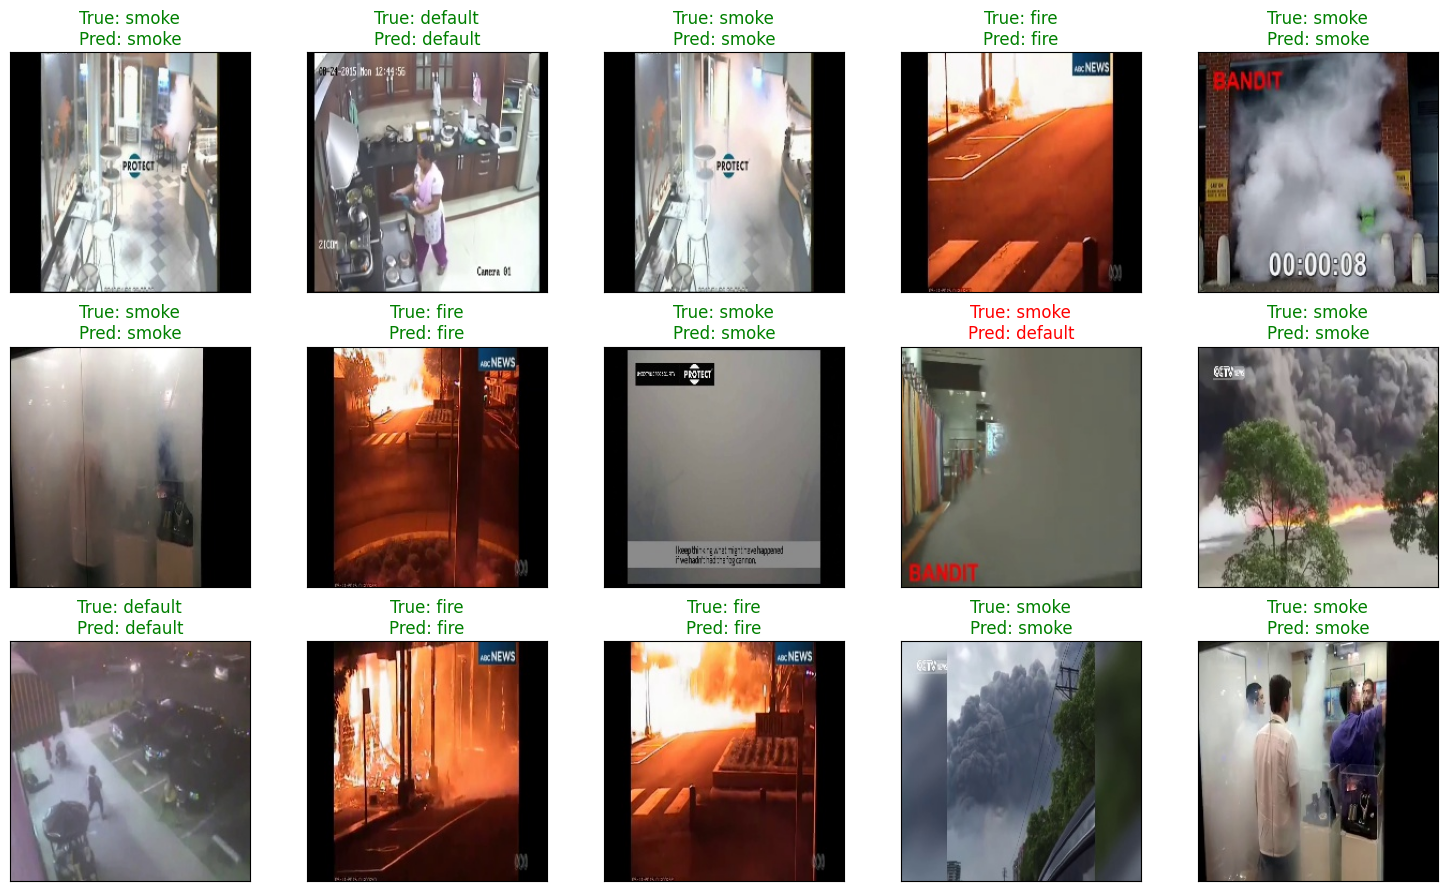

In [16]:
import numpy as np  # Sayısal işlemler için NumPy kütüphanesi

import matplotlib.pyplot as plt  # Görselleştirme işlemleri için matplotlib

from PIL import Image  # Görüntüleri açmak için PIL (Python Imaging Library)

# 1. Test verileri için model tahminlerini üret

pred_probs = model.predict(test_images)  # Her test görseli için sınıf olasılıklarını tahmin et

pred_indices = np.argmax(pred_probs, axis=1)  # En yüksek olasılığa sahip sınıfın indeksini al

index_to_class = {v: k for k, v in train_images.class_indices.items()}  # Sınıf indekslerini isimlere dönüştür

pred_labels = [index_to_class[idx] for idx in pred_indices]  # Tahmin edilen etiket isimlerini al

# 2. Rastgele 15 test görüntüsünü etiketlerle birlikte görselleştir

random_indices = np.random.randint(0, len(test_df), size=15)  # 15 adet rastgele test verisi seç

fig, axes = plt.subplots(3, 5, figsize=(15, 9),  # 3x5’lik görsel alanı oluştur

                         subplot_kw={'xticks': [], 'yticks': []})  # Eksen etiketlerini gizle

for ax, idx in zip(axes.flat, random_indices):

    img = Image.open(test_df.filepaths.iloc[idx])  # Görüntüyü dosya yolundan yükle

    ax.imshow(img)  # Görüntüyü göster
    
    true_label = test_df.labels.iloc[idx]  # Gerçek sınıf etiketi

    pred_label = pred_labels[idx]  # Tahmin edilen sınıf etiketi
    
    color = 'green' if true_label == pred_label else 'red'  # Doğruysa yeşil, yanlışsa kırmızı yaz

    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)  # Başlık olarak hem doğru hem tahmin edilen etiketi yaz

plt.tight_layout()  # Tüm grafiklerin birbirine karışmaması için düzenleme yap

plt.show()  # Sonuçları görsel olarak göster


In [17]:

# 12. Sınıflandırma Raporunu Yazdır

from sklearn.metrics import classification_report

# Gerçek test etiketlerini al

y_test = list(test_df.labels)

# Sınıflandırma raporunu yazdır (precision, recall, f1-score dahil)

print(classification_report(y_test, pred_labels))


              precision    recall  f1-score   support

     default       0.94      0.98      0.96        49
        fire       1.00      0.96      0.98        69
       smoke       0.96      0.98      0.97        55

    accuracy                           0.97       173
   macro avg       0.97      0.97      0.97       173
weighted avg       0.97      0.97      0.97       173



6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step


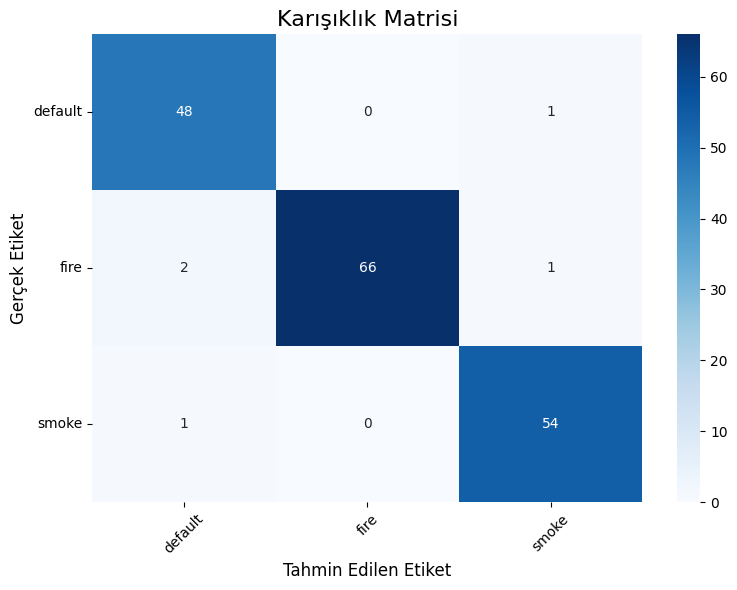

In [25]:
import numpy as np  # Sayısal işlemler için

import matplotlib.pyplot as plt  # Grafik çizimi için

from sklearn.metrics import confusion_matrix  # Karışıklık matrisi hesaplama

import seaborn as sns  # Isı haritası (heatmap) için

# Karışıklık matrisini çizen fonksiyon

def make_confusion_matrix(y_true, y_pred, class_names):

    cm = confusion_matrix(y_true, y_pred, labels=class_names)  # Matrisin hesaplanması

    plt.figure(figsize=(8, 6))  # Görselleştirme boyutu

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)  # Isı haritası çiz
    plt.title("Karışıklık Matrisi", fontsize=16)  # Başlık

    plt.xlabel("Tahmin Edilen Etiket", fontsize=12)  # X ekseni

    plt.ylabel("Gerçek Etiket", fontsize=12)  # Y ekseni

    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()  # Grafik taşmasını engelle

    plt.show()  # Grafiği göster


# Kullanım örneği


# 1. Gerçek etiketleri ve tahminleri al

y_true = test_df['labels'].values  # Gerçek etiketler

pred_probs = model.predict(test_images)  # Tahmin olasılıkları

pred_indices = np.argmax(pred_probs, axis=1)  # En yüksek olasılığı al

# 2. İndeksi sınıf adına çevir

index_to_class = {v: k for k, v in train_images.class_indices.items()}
y_pred = [index_to_class[i] for i in pred_indices]

# 3. Sınıf isimleri

class_names = ['default', 'fire', 'smoke']

# 4. Matris çiz

make_confusion_matrix(y_true, y_pred, class_names)


In [26]:
import matplotlib.pyplot as plt  # Grafik çizimi için

# Eğitim ve doğrulama doğruluk/kayıp eğrilerini çizen fonksiyon
def plot_loss_curves(history):
    loss = history.history['loss']  # Eğitim kaybı
    val_loss = history.history['val_loss']  # Doğrulama kaybı
    accuracy = history.history['accuracy']  # Eğitim doğruluğu
    val_accuracy = history.history['val_accuracy']  # Doğrulama doğruluğu

    epochs = range(len(loss))  # Epoch sayısı kadar x ekseni

    # Kayıp grafiği
    plt.figure(figsize =(10,4))
    plt.plot(epochs, loss, label='Eğitim Kaybı')
    plt.plot(epochs, val_loss, label='Doğrulama Kaybı')
    plt.title('Kayıp (Loss)')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()

    # Doğruluk grafiği
    plt.figure(figsize =(10,4))
    plt.plot(epochs, accuracy, label='Eğitim Doğruluğu')
    plt.plot(epochs, val_accuracy, label='Doğrulama Doğruluğu')
    plt.title('Doğruluk (Accuracy)')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()


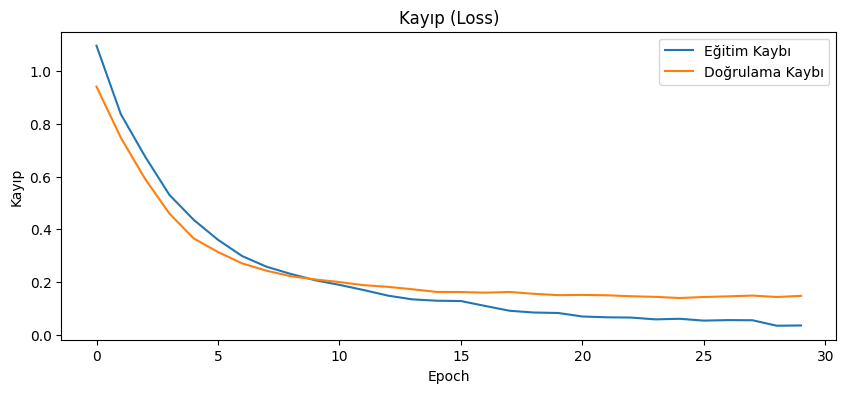

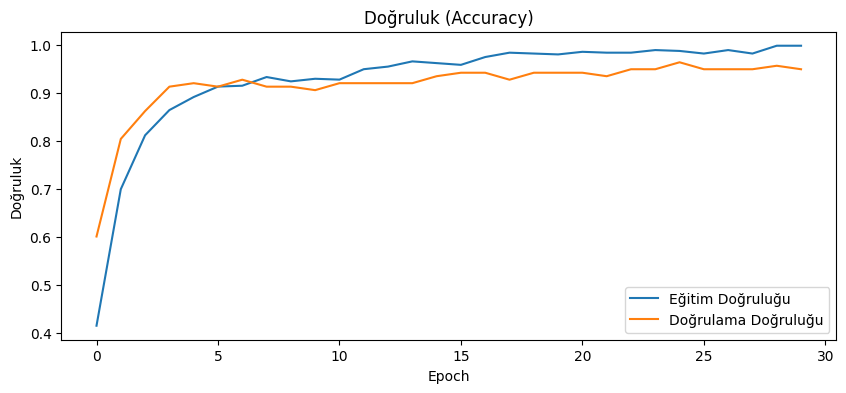

In [23]:
plot_loss_curves(history)


In [24]:
# 15. Test verisinde tahminleri alma


import numpy as np


# Test verisi için sınıf olasılıklarını tahmin et

pred_probs = model.predict(test_images)

# En yüksek olasılığa sahip sınıfın indeksini bul

pred_indices = np.argmax(pred_probs, axis=1)

# Sınıf adlarını indekslere göre ters çevir (örneğin {0: 'default', 1: 'fire', ...})

index_to_class = {v: k for k, v in train_images.class_indices.items()}

# Tahmin edilen sınıf adlarını al

pred_labels = [index_to_class[idx] for idx in pred_indices]

# İlk 5 tahmini yazdır

print(f'İlk 5 Tahmin: {pred_labels[:5]}')


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step
İlk 5 Tahmin: ['smoke', 'fire', 'fire', 'smoke', 'smoke']
